# Пример выбора модели из 2-x с помощью аппарата статистики
Подготовил: Глазунов А.В.

В данном блокноте я привожу пример подхода к подбору моделей по результатам кросс-валидации, которым сам пользуюсь регулярно. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mf-accelerator/contest_test.csv
/kaggle/input/mf-accelerator/sample_subm.csv
/kaggle/input/mf-accelerator/contest_train.csv


In [2]:
import pandas as pd

from matplotlib import pyplot as plt

import numpy as np
from sklearn.metrics import f1_score,make_scorer
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score,RepeatedStratifiedKFold

from catboost import CatBoostClassifier

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import ttest_1samp,ttest_rel
import statsmodels.stats.api as sms

Загрузка данных

In [3]:
data = pd.read_csv("../input/mf-accelerator/contest_train.csv")
target = data.TARGET
data = data.fillna(0)
features = data.drop(columns=["TARGET","ID"])
features.head()

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,0.000000,3.0,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,0.000000,3.0,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


Задание метрики и стратегии кросс-валидации. 

Обращаю внимание, что при каждом разбиении будет довольно большая валидационная выборка в 25%, но при этом данная стратегия позволяет получить в данном примере 20 значений метрики за счет разных random_state.

In [4]:
scorer = make_scorer(f1_score,average='macro')
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5,
      random_state=12)

Выберем между 2-мя моделями CatBoost, которые я упомянал в дискуссиях к соревнованию.

In [5]:
%%time
clf_cb = CatBoostClassifier(task_type='GPU',random_state=100, loss_function='MultiClass',
                            auto_class_weights="Balanced",iterations=2500,verbose=2500)  
 
scores = cross_val_score(clf_cb,features,target,scoring=scorer,cv=rskf)

Learning rate set to 0.054799
0:	learn: 1.0788681	total: 30.5ms	remaining: 1m 16s
2499:	learn: 0.2198368	total: 27.8s	remaining: 0us
Learning rate set to 0.0548
0:	learn: 1.0788455	total: 13.8ms	remaining: 34.4s
2499:	learn: 0.2232942	total: 27.9s	remaining: 0us
Learning rate set to 0.0548
0:	learn: 1.0791034	total: 25.9ms	remaining: 1m 4s
2499:	learn: 0.2231030	total: 27.3s	remaining: 0us
Learning rate set to 0.0548
0:	learn: 1.0780462	total: 13.1ms	remaining: 32.8s
2499:	learn: 0.2228654	total: 27.8s	remaining: 0us
Learning rate set to 0.054799
0:	learn: 1.0783705	total: 13.3ms	remaining: 33.3s
2499:	learn: 0.2214209	total: 27.3s	remaining: 0us
Learning rate set to 0.0548
0:	learn: 1.0780994	total: 12.6ms	remaining: 31.4s
2499:	learn: 0.2221647	total: 26.5s	remaining: 0us
Learning rate set to 0.0548
0:	learn: 1.0788561	total: 13ms	remaining: 32.5s
2499:	learn: 0.2245275	total: 28s	remaining: 0us
Learning rate set to 0.0548
0:	learn: 1.0791553	total: 12.7ms	remaining: 31.8s
2499:	lear

In [6]:
scores

array([0.53921886, 0.54598776, 0.53482989, 0.53705416, 0.52983451,
       0.53428804, 0.54772858, 0.54064646, 0.55622243, 0.53307519,
       0.54440268, 0.53295562, 0.54180581, 0.54275874, 0.53720063,
       0.54677955, 0.5398425 , 0.52764296, 0.54354231, 0.54832902])

In [7]:
print("Statistics score")
print("-------")
print(f"Mean: {scores.mean()}")
print(f"Std: {scores.std(ddof=1)}")
print(f"Max: {scores.max()}")
print(f"Min: {scores.min()}")
print("-------")

Statistics score
-------
Mean: 0.5402072864564988
Std: 0.007058269730805301
Max: 0.5562224312635077
Min: 0.5276429602637613
-------


Видно, какие высокие значения получились для метрики, но также можно заметить серьезный разброс между минимумом и максимумом. Поэтому, для уменьшения дисперсии на тестовой выборке в соревновании использовалось усреднение множества моделей.



Обучим 2-ю модель

In [8]:
%%time
clf_cb2 = CatBoostClassifier(task_type='GPU',random_state=100, loss_function='MultiClassOneVsAll',
                            auto_class_weights="Balanced",iterations=1050,
                           depth=7, l2_leaf_reg=1,verbose=1050)  
 
scores2 = cross_val_score(clf_cb2,features,target,scoring=scorer,cv=rskf)

0:	learn: 0.6849643	total: 15.3ms	remaining: 16.1s
1049:	learn: 0.2881179	total: 14.2s	remaining: 0us
0:	learn: 0.6845951	total: 16.3ms	remaining: 17.1s
1049:	learn: 0.2884479	total: 14.6s	remaining: 0us
0:	learn: 0.6847133	total: 15.4ms	remaining: 16.1s
1049:	learn: 0.2881575	total: 15.6s	remaining: 0us
0:	learn: 0.6846881	total: 15ms	remaining: 15.7s
1049:	learn: 0.2888734	total: 14s	remaining: 0us
0:	learn: 0.6846799	total: 15.9ms	remaining: 16.7s
1049:	learn: 0.2880778	total: 14.8s	remaining: 0us
0:	learn: 0.6845511	total: 16ms	remaining: 16.8s
1049:	learn: 0.2884775	total: 14s	remaining: 0us
0:	learn: 0.6848241	total: 15.7ms	remaining: 16.5s
1049:	learn: 0.2901034	total: 16.1s	remaining: 0us
0:	learn: 0.6848082	total: 16.1ms	remaining: 16.9s
1049:	learn: 0.2909001	total: 14s	remaining: 0us
0:	learn: 0.6847926	total: 16.4ms	remaining: 17.2s
1049:	learn: 0.2890037	total: 15s	remaining: 0us
0:	learn: 0.6847221	total: 17.2ms	remaining: 18.1s
1049:	learn: 0.2890995	total: 14.5s	remaini

In [9]:
scores2

array([0.54855117, 0.53762966, 0.53154708, 0.52756332, 0.52243955,
       0.53282864, 0.53876843, 0.54303313, 0.53048916, 0.52622855,
       0.54429671, 0.54354553, 0.5432872 , 0.54097157, 0.52066036,
       0.54131824, 0.52821475, 0.52501127, 0.52732152, 0.54159461])

In [10]:
print("Statistics score2")
print("-------")
print(f"Mean: {scores2.mean()}")
print(f"Std: {scores2.std(ddof=1)}")
print(f"Max: {scores2.max()}")
print(f"Min: {scores2.min()}")
print("-------")

Statistics score2
-------
Mean: 0.53476502257213
Std: 0.0084379146522442
Max: 0.54855116561817
Min: 0.5206603562481565
-------


Можно увидеть, что значения метрики меньше, чем в предыдущем случае,разброс больше. 

Осталось проверить статистическую значимость отличий. Вдруг разнице "на глаз" нельзя верить? 

Но пока необходимо провести несколько вспомогательных шагов, а именно, проверить нормальность выборок, чтобы воспользоваться одним из самых популярных статистических тестов.

Проверим нормальность выборки из значений метрики scores

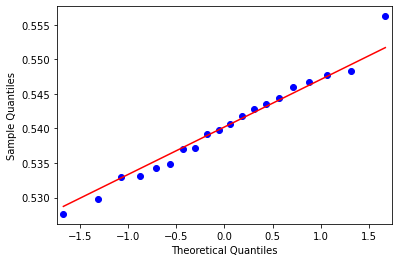

In [11]:
qqplot(scores,line = 's');

In [12]:
(s1,p1) = shapiro(scores)
print(f"The Shapiro-Wilk statistic value: {s1}")
print(f"p-value: {p1}")

The Shapiro-Wilk statistic value: 0.985202968120575
p-value: 0.9827545285224915


Выборка близка к нормальной, поскольку нулевая гипотеза о нормальности не отвергнута на уровне значимости 0.05 (p-value >> 0.05), а на графике точки близки к прямой.

Проверим нормальность выборки из значений метрик scores2.

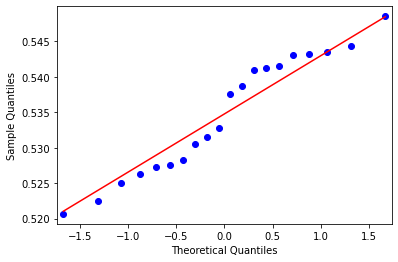

In [13]:
qqplot(scores2,line = 's');

In [14]:
(s2,p2) = shapiro(scores2)
print(f"The Shapiro-Wilk statistic value: {s2}")
print(f"p-value: {p2}")

The Shapiro-Wilk statistic value: 0.931646466255188
p-value: 0.1660967469215393


Выборка также близка к нормальной (хотя и в меньшей степени, чем для первой модели), теперь все готово, чтобы проверить статистическую значимость отличий в средних значениях метрик для каждого классификатора, чтобы понять, какой лучше. 

Для этого воспользуемся статистическим критерием Стьюдента для связанных выборок, потому что классификаторы обучаются и валидируются каждый раз на одинаковых подвыборках, идут синхронно.

In [15]:
ttest_rel(scores, scores2, axis=0)

Ttest_relResult(statistic=2.8467022862050486, pvalue=0.010316425818446344)

p-value << 0.05, поэтому нулевая гипотеза о равенстве средних отвергается в пользу альтернативы на уровне значимости 0.05, средние не равны.

Построим 95 % доверительный интервал для разности средних, чтобы удостовериться в знаке разности.

In [16]:
cm = sms.CompareMeans(sms.DescrStatsW(scores), sms.DescrStatsW(scores2))
print(cm.tconfint_diff(usevar='unequal'))

(0.0004574422272096267, 0.01042708554152809)


**Видно, что он не содержит ноль, при этом левая граница больше нуля, значит -  первая модель лучше, как и можно было догадаться, анализируя выборочные средние.**